# An example of using candex with source netCDF files in irregualr shape 
## Remapping of SCDNA to subbasins of South Saskatchewan River at Medicine Hat, Alberta, Canada.

In [ ]:
# download SCDNA data and convert it to Xarray-based format

import xarray as xr
import urllib.request
import numpy as np
import pandas as pd
import os
from datetime import datetime

pwd = '/Users/shg096/Desktop/' # folder where downloaded SCDNA is save
file_name = 'SCDNA_v1.1.nc' # name of the SCDNA saved

def download_process_SCDNA(pwd, file_name):
    
    # remove existing file is exists
    outfile = pwd+'/'+file_name
    if os.path.isfile (outfile):
        os.remove(outfile)
    
    # download the file
    print('Downloading SCDNA; this may take a while ...')
    print('Downloading starts at: ', datetime.now())
    url = 'http://zenodo.org/record/3953310/files/SCDNA_v1.1.nc4?download=1'
    urllib.request.urlretrieve(url, outfile)
    print('Downloading ends at: ', datetime.now())
    
    print('Formatting SCDNA and saving it in yearly files ...')
    print('Formatting starts at: ', datetime.now())
    ds = xr.open_dataset(outfile)
    nstn              = ds.LLE.shape[1] # number of stations
    ds = ds.rename({'nstn':'stn','nday':'time'}) # renaming
    ds['stn']  = np.arange(nstn) + 1 # ID of stations from 1 to the number of stations
    ds['time'] = pd.date_range(start=str(ds.date[0].values),\
                               end=str(ds.date[-1].values),freq='1D') # time
    ds = ds.set_coords('stn') # set stn as coordinate
    ds = ds.set_coords('time') # set time as coordinate
    ds['lat']   = ds.LLE[0, :] # pass lat values to a new variable
    ds['lon']   = ds.LLE[1, :] # pass lon values to a new variable
    ds['elev']  = ds.LLE[2, :] # pass elevation values to a new variable
    
    # get the sart and end year
    start_year = int(str(ds.date[0].values)[0:4])
    end_year   = int(str(ds.date[-1].values)[0:4])
    years  = list (np.arange(start_year, end_year+1))

    for year in years:
        year_str = str(year)
        outfile = pwd+'/SCDNA_v1.1.'+year_str+'.nc'
        ds_temp = ds.sel(time=slice(year_str,year_str))
        if os.path.isfile (outfile):
            os.remove(outfile) 
        ds_temp.to_netcdf(outfile)
        print ('Yearly SCDNA file is saved for '+year_str+' at '+ outfile)
    
    print('Formatting ends at: ', datetime.now())

# call the function
download_process_SCDNA(pwd, file_name)


Formatting SCDNA ...
Formatting starts at:  2021-02-14 14:42:26.577053


24615.0
19604.0
19611.0


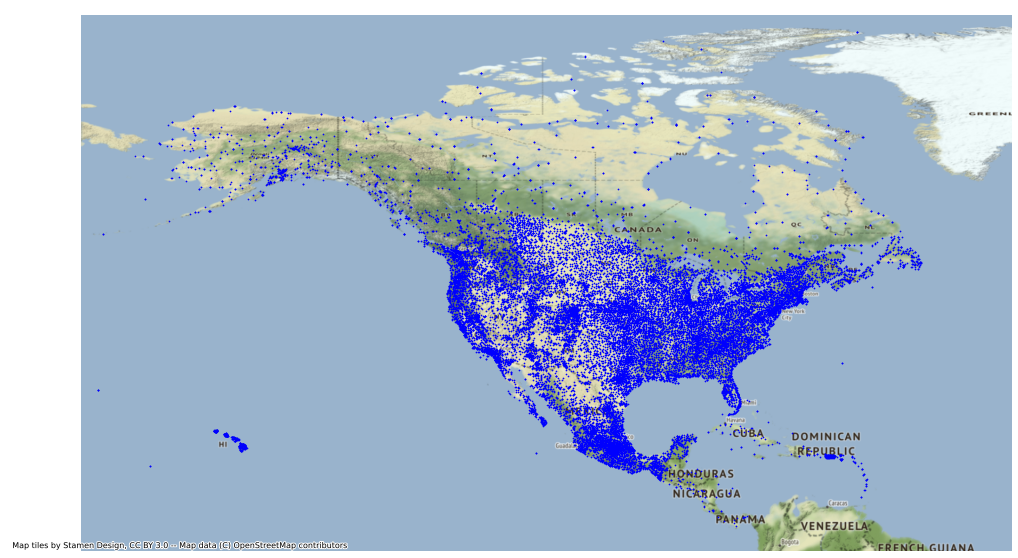

In [13]:
import xarray as xr
import pandas as pd
from   shapely.geometry import Point
import geopandas as gpd


infile = '/Users/shg096/Desktop/SCDNA_2017.nc'
outfile = '/Users/shg096/Desktop/SCDNA.shp'

def create_shp_SCDNA(infile, outfile):
    
    # load one the yearly nc files
    ds = xr.open_dataset(infile)
    
    nstn = ds.lat.shape[0] # number of stations

    points = pd.DataFrame()
    points['LATITUDE']  = ds.lat[:]
    points['LONGITUDE'] = ds.lon[:]
    points['ID']        = ds.stn[:]
    
    temp = ds['prcp'].isel(time=0).values
    stnvalid  = np.where(~np.isnan(temp))[0]
    temp = np.zeros(nstn)
    temp [stnvalid] = 1
    print(sum(temp))
    points['prcp_stn'] = temp
    
    temp = ds['tmin'].isel(time=0).values
    stnvalid  = np.where(~np.isnan(temp))[0]
    temp = np.zeros(nstn)
    temp [stnvalid] = 1
    print(sum(temp))
    points['tmin_stn'] = temp
    
    temp = ds['tmax'].isel(time=0).values
    stnvalid  = np.where(~np.isnan(temp))[0]
    temp = np.zeros(nstn)
    temp [stnvalid] = 1
    print(sum(temp))
    points['tmax_stn'] = temp


    # the columns of the DataFrame
    points['geometry'] = points.apply(lambda row: Point(row.LONGITUDE, row.LATITUDE ), axis=1) # set the geometry
    points  = gpd.GeoDataFrame(points) # pass this to a geopandas dataframe
    points = points.set_crs("EPSG:4326")
    points.to_file(outfile)
    
create_shp_SCDNA(infile, outfile)


## visualizing the point shapefile
import contextily as ctx
import matplotlib.pyplot as plt

stations = gpd.read_file(outfile)

fig, ax = plt.subplots(figsize=(18, 10))
stations.plot(ax=ax, color='blue', markersize = 0.5)
ax.axis('off')
plt.axis('equal')
ctx.add_basemap(ax, zoom=4, crs='EPSG:4326')
plt.show()


<ipython-input-14-a3bc5bb87f32>:19: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations_buffert = stations.buffer(1) # add a buffer of 1 degree to the stations shapefile


   ID_bounding                                           geometry
0          1.0  POLYGON ((-178.38333 7.08560, -178.38333 83.51...


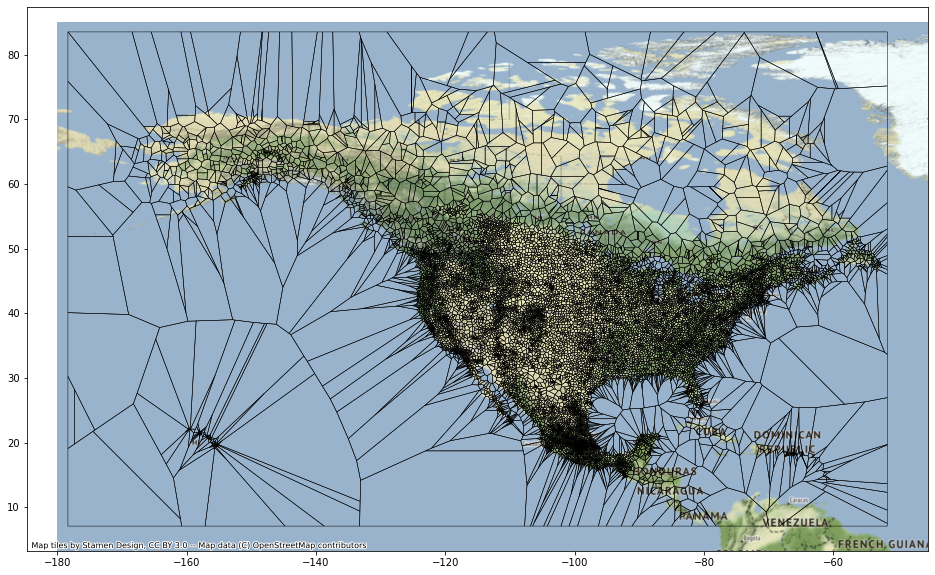

In [14]:
import shapefile
import geovoronoi
import os
from   shapely.geometry import Polygon
import numpy as np


infile = '/Users/shg096/Desktop/SCDNA.shp'
outfile =  '/Users/shg096/Desktop/SCDNA_voronoi.shp'

def voronoi_diagram(infile, outfile):
    
    
    # read the shapefile
    stations = gpd.read_file(infile)
    stations = stations[stations['tmin_stn']==1]
    
    # get the total boundary of the shapefile
    stations_buffert = stations.buffer(1) # add a buffer of 1 degree to the stations shapefile
    minx, miny, maxx, maxy = stations_buffert.total_bounds
    
    # create the bounding shapefile
    parts = []
    with shapefile.Writer('test.shp') as w:
        w.autoBalance = 1 # turn on function that keeps file stable if number of shapes and records don't line up
        w.field("ID_bounding",'N') # create (N)umerical attribute fields, integer

        # creating the polygon given the lat and lon
        parts.append([ (minx, miny),\
                       (minx, maxy), \
                       (maxx, maxy), \
                       (maxx, miny), \
                       (minx, miny)])

        # store polygon
        w.poly(parts)

        # update records/fields for the polygon
        w.record(1)

    boundary = gpd.read_file('test.shp')
    print(boundary)
    os.remove('test.shp')
    
    # create the voroni diagram for given point shapefile
    coords = geovoronoi.points_to_coords(stations.geometry)

    poly_shapes, location = \
    geovoronoi.voronoi_regions_from_coords(coords, boundary.iloc[0].geometry)
    
    
    # pass te polygons to shapefile
    Thiessen = gpd.GeoDataFrame()
    Thiessen['geometry'] = None
    Thiessen['ID'] = None
    Thiessen['LATITUDE'] = None
    Thiessen['LONGITUDE'] = None


    for i in np.arange(len(poly_shapes)):
        Thiessen.loc[i, 'geometry'] = Polygon(poly_shapes[i])
        Thiessen.loc[i, 'ID']       = stations.iloc[location[i][0]].ID.astype(float)
        Thiessen.loc[i, 'LATITUDE'] = stations.iloc[location[i][0]].LATITUDE.astype(float)
        Thiessen.loc[i, 'LONGITUDE']= stations.iloc[location[i][0]].LONGITUDE.astype(float)
    
    Thiessen = Thiessen.set_crs("EPSG:4326")

    Thiessen.to_file(outfile)
    
voronoi_diagram(infile, outfile)

## visualization
Thiessen = gpd.read_file(outfile)
fig, ax = plt.subplots(figsize=(18, 10))
Thiessen.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0.5 , figsize=(15,30),ax=ax)
ctx.add_basemap(ax, zoom=4, crs='EPSG:4326')


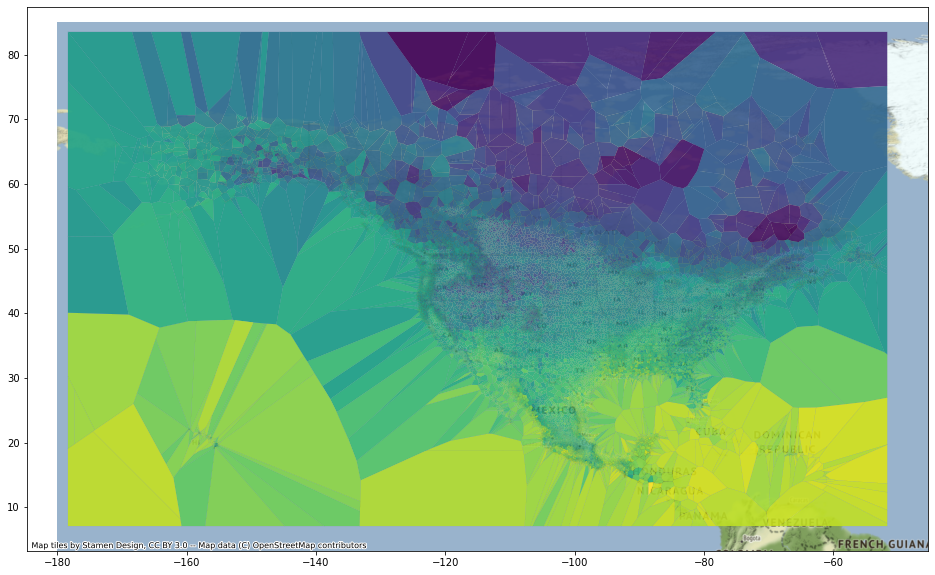

In [15]:
ds = xr.open_dataset('/Users/shg096/Desktop/SCDNA_2017.nc')
Thiessen = gpd.read_file(outfile)
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')

#
df = pd.DataFrame()
df ['values']     = ds.tmin.sel(time='2017-01-01')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)

df = df.dropna() # drop the values that are NaN
df = df.sort_values(by='ID')# sort on values

Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')


In [16]:
# loading candex
from candex import candex

# initializing candex object
cndx = candex()

# specifying candex needed arguments
cndx.name_of_case             = 'SCDNA_Medicine_Hat' # name of the case
cndx.temporary_candex_folder  = '../temporary/' # temporary path that the candex generated GIS files and rempped file will be saved
cndx.name_of_target_shp       = '../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp' # target shapefile that the source will be remmaped to
cndx.name_of_nc_files         = '/Users/shg096/Desktop/slice_SCDNA/SCDNA_*.nc' # name of netCDF file(s) if multiple you can specify with *
cndx.name_of_var_name         = ['tmin'] # name of variables from source netCDF file(s) to be remapped
cndx.name_of_var_lon          = 'lon' # name of varibale longitude in source netCDF files 
cndx.name_of_var_lat          = 'lat' # name of variable latitude in source netCDF files
cndx.name_of_var_time         = 'time' # name of varibale time in source netCDF file
cndx.name_of_shp_for_nc_files = '/Users/shg096/Desktop/SCDNA_voronoi.shp'
cndx.name_of_field_target_lat_shp_for_nc_files  =  'LATITUDE' # name_of_nc_files
cndx.name_of_field_target_lon_shp_for_nc_files  =  'LONGITUDE'
cndx.name_of_nc_output_folder = '../output/' # location where the remapped netCDF file will be saved
cndx.format_list              =  ['f4']#,'f4'] # format of the varibales to be saved with
cndx.fill_value_list          = ['-9999.00']#,'-9999.00'] # missing values for the varibales
# cndx.name_of_remap_file        = '../temporary/ERA5_Medicine_Hat_remapping.csv' # if uncommneted candex will use this and skip GIS taskes

# execute candex
cndx.run_candex()





no  author name is provide and the author name is changes to (author name)
candex detects that target shapefile is in WGS84 (epsg:4326)
candex detects that no fields are provided for ID, lat, lon and will assign those by itself
candex will save standard shapefile for candex claculation as:
../temporary/SCDNA_Medicine_Hat_target_shapefile.shp


/Users/shg096/Desktop/candex_newgen/candex/candex.py:128: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp['lat_t'] = shp.centroid.y # centroid lat from target
/Users/shg096/Desktop/candex_newgen/candex/candex.py:129: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp['lon_t'] = shp.centroid.x # centroid lon from target


candex detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
candex detects that all the varibales have dimensions of:
['stn', 'time']
candex detects that the longitude varibales has dimensions of:
['stn']
candex detects that the latitude varibales has dimensions of:
['stn']
candex detects case 3 - irregular lat/lon; shapefile should be provided
[48.87   48.6    48.58   ... 20.9625 47.5083 21.3167] [-123.28   -123.47   -123.42   ... -156.6753 -115.9461 -158.0667]
candex detects that no varibale for ID of the source netCDF file; an arbitatiry ID will be provided
candex decides the netCDF file has longtitude values of -180 to 180; creating the extended
candex saved the expanded shapefile at:
../temporary/SCDNA_Medicine_Hat_source_shapefile_expanded.shp
candex detects that source shapefile is in WGS84 (epsg:4326)
checking latitude and longitude values from source shapefile and nc file
this may take a while
progress:  5.1046

/Users/shg096/Desktop/candex_newgen/candex/candex.py:645: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_1['AS1'] = shp_1.area
/Users/shg096/Desktop/candex_newgen/candex/candex.py:649: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_2['AS2'] = shp_2.area
/Users/shg096/Desktop/candex_newgen/candex/candex.py:744: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
/Users/shg096/Desktop/candex_newgen/candex/candex.py:748: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.Ge

Remapping /Users/shg096/Desktop/slice_SCDNA/SCDNA_1979.nc to ../output/SCDNA_Medicine_Hat_remapped_1979-01-01-00-00-00.nc
Started at date and time 2021-02-14 22:47:42.367624
Ended   at date and time 2021-02-14 22:47:54.280233
Remapping /Users/shg096/Desktop/slice_SCDNA/SCDNA_1980.nc to ../output/SCDNA_Medicine_Hat_remapped_1980-01-01-00-00-00.nc
Started at date and time 2021-02-14 22:47:54.304378
Ended   at date and time 2021-02-14 22:48:05.649247
Remapping /Users/shg096/Desktop/slice_SCDNA/SCDNA_1981.nc to ../output/SCDNA_Medicine_Hat_remapped_1981-01-01-00-00-00.nc
Started at date and time 2021-02-14 22:48:05.672766
Ended   at date and time 2021-02-14 22:48:16.946640
Remapping /Users/shg096/Desktop/slice_SCDNA/SCDNA_1982.nc to ../output/SCDNA_Medicine_Hat_remapped_1982-01-01-00-00-00.nc
Started at date and time 2021-02-14 22:48:16.972896
Ended   at date and time 2021-02-14 22:48:27.729796
Remapping /Users/shg096/Desktop/slice_SCDNA/SCDNA_1983.nc to ../output/SCDNA_Medicine_Hat_remapp

Ended   at date and time 2021-02-14 22:55:01.613623
Remapping /Users/shg096/Desktop/slice_SCDNA/SCDNA_2016.nc to ../output/SCDNA_Medicine_Hat_remapped_2016-01-01-00-00-00.nc
Started at date and time 2021-02-14 22:55:01.635194
Ended   at date and time 2021-02-14 22:55:15.028715
Remapping /Users/shg096/Desktop/slice_SCDNA/SCDNA_2017.nc to ../output/SCDNA_Medicine_Hat_remapped_2017-01-01-00-00-00.nc
Started at date and time 2021-02-14 22:55:15.051981
Ended   at date and time 2021-02-14 22:55:27.667533
Remapping /Users/shg096/Desktop/slice_SCDNA/SCDNA_2018.nc to ../output/SCDNA_Medicine_Hat_remapped_2018-01-01-00-00-00.nc
Started at date and time 2021-02-14 22:55:27.695687
Ended   at date and time 2021-02-14 22:55:40.367240


<AxesSubplot:>

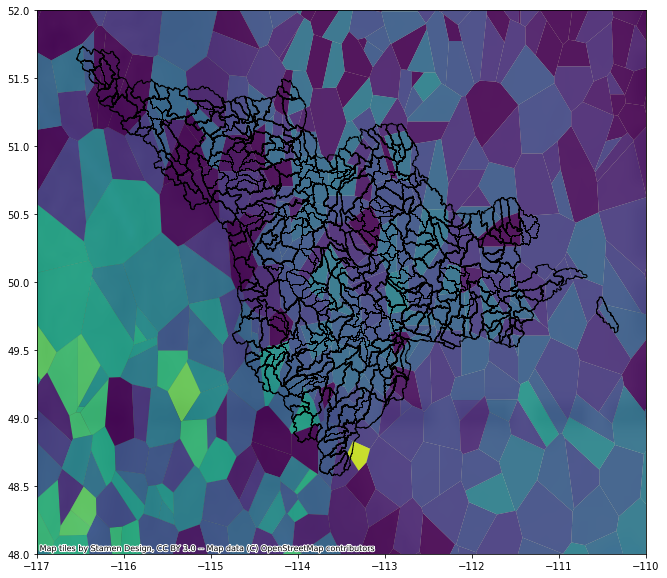

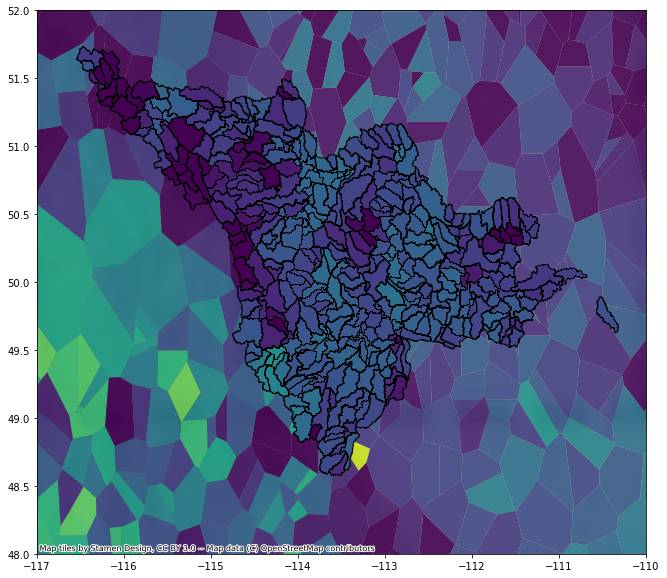

In [21]:
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx



ds = xr.open_dataset('/Users/shg096/Desktop/SCDNA_2017.nc')
Thiessen = gpd.read_file('/Users/shg096/Desktop/SCDNA_voronoi.shp')
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')
shp_target = gpd.read_file(cndx.temporary_candex_folder+ cndx.name_of_case +\
                           '_target_shapefile.shp') # load the target shapefile
shp_target = shp_target.sort_values(by='ID_t')


#
df = pd.DataFrame()
df ['values']     = ds.tmin.sel(time='2017-01-01')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)


df = df.dropna() # drop the values that are NaN
df = df.sort_values(by='ID')# sort on values

Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax, vmin=-20, vmax = 0)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.xlim([-117, -110])
plt.ylim([  48,   52])
shp_target.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 1 , figsize=(15,30),ax=ax)


## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax, vmin=-20, vmax = 0)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.xlim([-117, -110])
plt.ylim([  48,   52])

ds2 = xr.open_dataset('../output/SCDNA_Medicine_Hat_remapped_2017-01-01-00-00-00.nc')

shp_target ['values'] = ds2.tmin.sel(time='2017-01-01')

shp_target.plot(column='values', edgecolor='k',linewidth = 1 , figsize=(15,30),ax=ax, vmin=-20, vmax = 0)
